# Virtual Twins (VT) Method for Estimating Individual Treatment Effects (ITE)

The Virtual Twins (VT) method is a machine learning approach to estimating Individual Treatment Effects (ITE) in randomized controlled trials (RCTs). This method involves multiple steps, including data preparation, training predictive models, computing ITE, and identifying subgroups that benefit from treatment.

---

## Step 1: Data Preparation
Before implementing the VT method, we must ensure that the dataset is clean and formatted correctly. The dataset contains a binary outcome (*survival*), a treatment variable (*THERAPY*), and several covariates.

### Mathematical Formulation:
Let:

- \( Y \) be the outcome variable (survival).
- \( T \) be the treatment assignment (*THERAPY*), where \( T = 1 \) represents treatment and \( T = 0 \) represents control.
- \( X \) be the set of covariates describing patient characteristics.

The goal is to estimate the probability of survival under each treatment condition:

$$
P(Y = 1 \mid T = 1, X = x) \quad \text{and} \quad P(Y = 1 \mid T = 0, X = x).
$$

### Implementation:
- Load the dataset from a `.csv` file.
- Define the outcome (*survival*) and treatment (*THERAPY*) variables.
- Preprocess the data by handling missing values and encoding categorical variables if necessary.

---

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from Functions.vt_data import VTObject, vt_data_python
from Functions.vt_data import VTForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Load dataset
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(470))

✅ Dataset Loaded Successfully
     survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM   BLIL6     BLLPLAT  \
0           0        1        19  42.921     15         1   301.8  191.000000   
1           1        1        48  68.818     11         2   118.9  264.156481   
2           0        1        20  68.818     15         2    92.8  123.000000   
3           0        1        19  33.174     14         2  1232.0  244.000000   
4           0        1        48  46.532      3         4  2568.0   45.000000   
..        ...      ...       ...     ...    ...       ...     ...         ...   
465         0        0        19  65.891     15         3    37.1  359.000000   
466         1        0        25  33.174      3         1   212.3  137.000000   
467         0        0        19  59.871     14         1    37.1  650.000000   
468         0        0        19  38.113     10         1    37.1  191.000000   
469         0        0        37  73.138      3         2    92.8  153.000000  

## Step 2: Simple Random Forest Approach
The **Simple Random Forest Approach** trains a single **Random Forest model** on the **entire dataset**, including both treated and control patients. This model directly predicts the **individual treatment effect (ITE)**.

### Mathematical Formulation:
Instead of training separate models for treated and control groups, we train a single model:

$$
P(Y = 1 \mid T, X)
$$

This model learns the probability of survival given both the treatment and covariates.

### Implementation:
1. Train a **single Random Forest model** using the entire dataset, including the treatment variable.
2. Use the model to predict survival probabilities for both scenarios:
   - **With treatment** $( T = 1 )$.
   - **Without treatment** $( T = 0 )$.
3. Compute **ITE** by taking the difference between the predicted probabilities.

This approach is computationally simpler but may introduce bias compared to the **Double Random Forest Approach**.

---

### MANUAL SIMPLE RANDOM FOREST 

In [11]:
# Load dataset
file_path = os.path.join("dataset", "sepsis_dataset.csv")
sepsis_data = pd.read_csv(file_path)

# Define key fields
outcome_field = "survival"
treatment_field = "THERAPY"
covariates = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]

# Convert categorical to numeric
sepsis_data = pd.get_dummies(sepsis_data, columns=covariates, drop_first=True)

# Separate treated and control
treated = sepsis_data[sepsis_data[treatment_field] == 1]
control = sepsis_data[sepsis_data[treatment_field] == 0]

X_treated = treated.drop(columns=[outcome_field, treatment_field])
y_treated = treated[outcome_field]
X_control = control.drop(columns=[outcome_field, treatment_field])
y_control = control[outcome_field]

# Standardize features
scaler = StandardScaler()
X_treated_scaled = scaler.fit_transform(X_treated)
X_control_scaled = scaler.fit_transform(X_control)
X_all_scaled = scaler.transform(sepsis_data.drop(columns=[outcome_field, treatment_field]))

# Train models
rf_treated = RandomForestClassifier(n_estimators=100, random_state=42)
rf_control = RandomForestClassifier(n_estimators=100, random_state=42)
rf_treated.fit(X_treated_scaled, y_treated)
rf_control.fit(X_control_scaled, y_control)

# Predict probabilities
P1_full = rf_treated.predict_proba(X_all_scaled)[:, 1]
P0_full = rf_control.predict_proba(X_all_scaled)[:, 1]
ITE = P1_full - P0_full

# Add to dataframe
sepsis_data["P1_hat"] = P1_full
sepsis_data["P0_hat"] = P0_full
sepsis_data["ITE"] = ITE
sepsis_data["Effect Label"] = sepsis_data["ITE"].apply(
    lambda x: "Beneficial" if x > 0 else ("Harmful" if x < 0 else "No Effect")
)

# Save
output_path = os.path.join("dataset", "manual_vt_results.csv")
sepsis_data.to_csv(output_path, index=False)
print(f"📁 Manual VT Results saved to: {output_path}")

# Preview
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect Label"]].head(10))


📁 Manual VT Results saved to: dataset\manual_vt_results.csv
   P1_hat  P0_hat   ITE Effect Label
0    0.18    0.39 -0.21      Harmful
1    0.85    0.48  0.37   Beneficial
2    0.13    0.31 -0.18      Harmful
3    0.16    0.36 -0.20      Harmful
4    0.19    0.40 -0.21      Harmful
5    0.34    0.18  0.16   Beneficial
6    0.31    0.69 -0.38      Harmful
7    0.11    0.23 -0.12      Harmful
8    0.10    0.41 -0.31      Harmful
9    0.76    0.36  0.40   Beneficial


### VT-METHOD SIMPLE RANDOM FOREST 

In [48]:
# Load dataset
data_path = os.path.join("dataset", "sepsis_dataset.csv")
sepsis_data = pd.read_csv(data_path)

outcome_field = "survival"
treatment_field = "THERAPY"

# Prepare data using VTObject
vt_object = VTObject(sepsis_data, outcome_field, treatment_field, interactions=True)
X = vt_object.get_X()
y = vt_object.get_Y()
treatment = vt_object.get_treatment()

# Split treated vs control
X_treated, y_treated = X[treatment == 1], y[treatment == 1]
X_control, y_control = X[treatment == 0], y[treatment == 0]

# Train models
rf_treated = RandomForestClassifier(n_estimators=500, random_state=123)
rf_control = RandomForestClassifier(n_estimators=500, random_state=123)
rf_treated.fit(X_treated, y_treated)
rf_control.fit(X_control, y_control)

# Predict and compute ITE
P1_hat = rf_treated.predict_proba(X)[:, 1]
P0_hat = rf_control.predict_proba(X)[:, 1]
ITE = P1_hat - P0_hat

# Attach to original dataframe
sepsis_data = sepsis_data.copy()
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE
sepsis_data["Effect Label"] = sepsis_data["ITE"].apply(
    lambda x: "Beneficial" if x > 0 else ("Harmful" if x < 0 else "No Effect")
)

# Save
output_path = os.path.join("dataset", "SimpleRandomResult.csv")
sepsis_data.to_csv(output_path, index=False)
print(f"📁 VTObject Results saved to: {output_path}")

# Preview
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect Label"]].head(10))


📁 VTObject Results saved to: dataset\SimpleRandomResult.csv
   P1_hat  P0_hat    ITE Effect Label
0   0.146   0.438 -0.292      Harmful
1   0.940   0.466  0.474   Beneficial
2   0.130   0.392 -0.262      Harmful
3   0.056   0.374 -0.318      Harmful
4   0.132   0.420 -0.288      Harmful
5   0.392   0.136  0.256   Beneficial
6   0.348   0.794 -0.446      Harmful
7   0.012   0.434 -0.422      Harmful
8   0.042   0.356 -0.314      Harmful
9   0.748   0.364  0.384   Beneficial


## Step 3: Double Random Forest Approach (More Robust)
To improve accuracy, we implement the **Double Random Forest Approach**, which trains two separate models:

$$
\hat{P}_1(X) = P(Y = 1 \mid T = 1, X)
$$

$$
\hat{P}_0(X) = P(Y = 1 \mid T = 0, X)
$$

where:

- $( \hat{P}_1(X) )$ is the predicted probability of survival under treatment.
- $( \hat{P}_0(X) )$ is the predicted probability of survival under control.

### Implementation:
1. Train **one Random Forest model** using only the **treated group** $( T = 1 )$.
2. Train **another Random Forest model** using only the **control group** $( T = 0 )$.
3. Compute **ITE** for each patient:

   $$
   ITE_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
   $$

### **Comparison of Approaches**
| Approach                  | Description | Strengths | Weaknesses |
|---------------------------|-------------|------------|------------|
| **Simple Random Forest** | Single RF model trained on entire dataset | Computationally efficient | May introduce bias |
| **Double Random Forest** | Separate RF models for treated and control groups | More accurate | Requires more computational power |

---

### MANUAL DOUBLE RANDOM FOREST 

In [14]:
# Step 1: Load the Dataset
file_path = os.path.join("dataset", "sepsis_dataset.csv")
sepsis_data = pd.read_csv(file_path)

# Step 2: Define Outcome and Treatment Fields
outcome_field = "survival"     # Binary outcome (1 = survived, 0 = died)
treatment_field = "THERAPY"    # 1 = active treatment, 0 = control

# Step 3: Separate Features (X), Target (y), and Treatment
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X = sepsis_data[features]
y = sepsis_data[outcome_field]
treatment = sepsis_data[treatment_field]

# Step 4: Split Data into Treated and Control Groups
X_treated = X[treatment == 1].copy()
y_treated = y[treatment == 1].copy()

X_control = X[treatment == 0].copy()
y_control = y[treatment == 0].copy()

# Step 5: Train Random Forest Models Separately
print("🚀 Training Double Random Forest Models...")

rf_treated = RandomForestClassifier(n_estimators=200, random_state=123)
rf_control = RandomForestClassifier(n_estimators=200, random_state=123)

rf_treated.fit(X_treated, y_treated)
rf_control.fit(X_control, y_control)

print("✅ Double Random Forest Training Complete")

# Step 6: Predict Outcomes for All Individuals
P1_hat = rf_treated.predict_proba(X)[:, 1]  # Probability of survival if treated
P0_hat = rf_control.predict_proba(X)[:, 1]  # Probability of survival if not treated

# Step 7: Calculate Individual Treatment Effect (ITE)
ITE = P1_hat - P0_hat

# Step 8: Interpret ITE with Effect Labels
def label_effect(ite_value):
    if ite_value > 0:
        return "Beneficial"
    elif ite_value < 0:
        return "Harmful"
    else:
        return "No Effect"

effect_labels = [label_effect(val) for val in ITE]

# Step 9: Combine Results into the Original DataFrame
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE
sepsis_data["Effect_Label"] = effect_labels

# Step 10: Save the Resulting DataFrame
output_path = os.path.join("dataset", "sepsis_dataset_with_ITE.csv")
sepsis_data.to_csv(output_path, index=False)

print("✅ ITE computation complete. Results saved to:", output_path)
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(10))

🚀 Training Double Random Forest Models...
✅ Double Random Forest Training Complete
✅ ITE computation complete. Results saved to: dataset\sepsis_dataset_with_ITE.csv
   P1_hat  P0_hat    ITE Effect_Label
0   0.125   0.470 -0.345      Harmful
1   0.955   0.470  0.485   Beneficial
2   0.125   0.375 -0.250      Harmful
3   0.055   0.315 -0.260      Harmful
4   0.115   0.475 -0.360      Harmful
5   0.255   0.135  0.120   Beneficial
6   0.280   0.830 -0.550      Harmful
7   0.025   0.470 -0.445      Harmful
8   0.040   0.300 -0.260      Harmful
9   0.770   0.395  0.375   Beneficial


### VT-METHOD DOUBLE RANDOM FOREST 

In [49]:
# Step 1: Load dataset
data_path = os.path.join("dataset", "sepsis_dataset.csv")
sepsis_data = pd.read_csv(data_path)

# Step 2: Define outcome and treatment variables
outcome_field = "survival"    # 1 = died, 0 = survived
treatment_field = "THERAPY"   # 1 = active treatment, 0 = control

# Step 3: Initialize VTObject with interactions enabled
vt_object = VTObject(sepsis_data, outcome_field, treatment_field, interactions=True)

# Step 4: Extract data from VTObject
X = vt_object.get_X()
y = vt_object.get_Y()
treatment = vt_object.get_treatment()

# Step 5: Subset into treated and control groups
X_treated = X[treatment == 1]
y_treated = y[treatment == 1]
X_control = X[treatment == 0]
y_control = y[treatment == 0]

# Step 6: Train Random Forest Models
print("🚀 Training Double Random Forest Models using Virtual Twin...")

model_rf_trt1 = RandomForestClassifier(n_estimators=200, random_state=123)
model_rf_trt0 = RandomForestClassifier(n_estimators=200, random_state=123)

model_rf_trt1.fit(X_treated, y_treated)
model_rf_trt0.fit(X_control, y_control)

print("✅ Double Random Forest Training Complete")

# Step 7: Apply Virtual Twin double forest
vt_double_forest = VTForest(
    forest_type="double",
    vt_data=vt_object,
    model_trt1=model_rf_trt1,
    model_trt0=model_rf_trt0
)

# Step 8: Compute ITE and probabilities
P1_hat = vt_double_forest.P1_hat
P0_hat = vt_double_forest.P0_hat
ITE = P1_hat - P0_hat

# Step 9: Add results to the original dataset
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE

# Step 10: Add effect label
def label_effect(ite):
    if ite > 0:
        return "Beneficial"
    elif ite < 0:
        return "Harmful"
    else:
        return "No Effect"

sepsis_data["Effect_Label"] = sepsis_data["ITE"].apply(label_effect)

# Step 11: Save results
output_path = os.path.join("dataset", "DoubleRandomResult.csv")
sepsis_data.to_csv(output_path, index=False)

print(f"📁 Results saved to: {output_path}")
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(10))

🚀 Training Double Random Forest Models using Virtual Twin...
✅ Double Random Forest Training Complete
📁 Results saved to: dataset\DoubleRandomResult.csv
   P1_hat  P0_hat    ITE Effect_Label
0   0.130   0.440 -0.310      Harmful
1   0.935   0.405  0.530   Beneficial
2   0.125   0.390 -0.265      Harmful
3   0.060   0.380 -0.320      Harmful
4   0.100   0.455 -0.355      Harmful
5   0.425   0.155  0.270   Beneficial
6   0.390   0.790 -0.400      Harmful
7   0.015   0.390 -0.375      Harmful
8   0.030   0.340 -0.310      Harmful
9   0.745   0.365  0.380   Beneficial


## Step 4: Classification of Beneficiaries
We use a classifier (e.g., another **Random Forest**) to identify subgroups of patients who benefit the most from treatment.

### Mathematical Formulation:
A classification model is trained to predict whether a patient benefits from treatment based on their covariates:

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

where $( Z_i )$ is an indicator variable denoting whether the treatment is beneficial for patient $( i )$.

### Implementation:
- Train a classifier using the estimated $( ITE )$ values.
- Identify the subgroups for which the treatment is most effective.

---

## Step 5: K-Fold Cross-Validation for Robustness
Instead of training models on the full dataset, we use **K-Fold Cross-Validation** to prevent overfitting. This ensures that the model does not use the same data for training and prediction.

### Implementation:
- Split the dataset into $( k )$ folds.
- Train the model on $( k-1 )$ folds and test it on the remaining fold.
- Repeat $( k )$ times and average the results.

---

### MANUAL K-FOLD RANDOM FOREST 

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Step 1: Load dataset and define fields
sepsis_data = pd.read_csv("dataset/sepsis_dataset.csv")
outcome_field = "survival"        # Binary outcome
treatment_field = "THERAPY"       # 1 = treated, 0 = control

# Step 2: Extract features and variables
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X = sepsis_data[features].values
y = sepsis_data[outcome_field].values
treatment = sepsis_data[treatment_field].values

# Step 3: Set up K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Step 4: Initialize placeholders
P1_hat = np.zeros(len(X))  # For treated model
P0_hat = np.zeros(len(X))  # For control model

# Step 5: Run K-Fold Cross-Validation
print(f"🚀 Running {k_folds}-Fold Cross-Validation (Manual)...")

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    trt_train = treatment[train_idx]

    # Split train set by treatment
    X_train_treat = X_train[trt_train == 1]
    y_train_treat = y_train[trt_train == 1]

    X_train_control = X_train[trt_train == 0]
    y_train_control = y_train[trt_train == 0]

    # Train models
    rf_treat = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_treat.fit(X_train_treat, y_train_treat)

    rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_control.fit(X_train_control, y_train_control)

    # Predict survival probabilities
    P1_hat[test_idx] = rf_treat.predict_proba(X_test)[:, 1]
    P0_hat[test_idx] = rf_control.predict_proba(X_test)[:, 1]

# Step 6: Compute ITE
ITE = P1_hat - P0_hat
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE

# Step 7: Label effects
def label_effect(ite):
    if ite > 0.01:
        return "Beneficial"
    elif ite < -0.01:
        return "Harmful"
    else:
        return "Neutral"

sepsis_data["Effect_Label"] = sepsis_data["ITE"].apply(label_effect)

# Step 8: Save results
sepsis_data.to_csv("dataset/sepsis_KFold_Manual_ITE.csv", index=False)

# Step 9: Show preview
print("✅ Manual K-Fold Done")
print("📄 Manual Double Random Forest (K-Fold) — Preview")
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(10))


🚀 Running 5-Fold Cross-Validation (Manual)...
✅ Manual K-Fold Done
📄 Manual Double Random Forest (K-Fold) — Preview
   P1_hat  P0_hat    ITE Effect_Label
0   0.260   0.625 -0.365      Harmful
1   0.770   0.600  0.170   Beneficial
2   0.250   0.360 -0.110      Harmful
3   0.145   0.290 -0.145      Harmful
4   0.395   0.395  0.000      Neutral
5   0.205   0.430 -0.225      Harmful
6   0.350   0.450 -0.100      Harmful
7   0.120   0.475 -0.355      Harmful
8   0.175   0.345 -0.170      Harmful
9   0.245   0.195  0.050   Beneficial


### VT-METHOD K-FOLD RANDOM FOREST 

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Step 1: Load dataset and define fields
sepsis_data = pd.read_csv("dataset/sepsis_dataset.csv")
outcome_field = "survival"        # Binary outcome
treatment_field = "THERAPY"       # 1 = treated, 0 = control

# Step 2: Extract features and variables
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X = sepsis_data[features].values
y = sepsis_data[outcome_field].values
treatment = sepsis_data[treatment_field].values

# Step 3: Set up K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Step 4: Initialize placeholders for predictions
P1_hat = np.zeros(len(X))  # For treated model
P0_hat = np.zeros(len(X))  # For control model

# Function for creating interaction terms
def create_interactions(X, treatment, interactions=True):
    if interactions:
        # Create interaction terms between treatment and features
        interaction_features = np.hstack([X, treatment.reshape(-1, 1) * X])  # Treatment interaction
        return interaction_features
    return X

# Step 5: Run K-Fold Cross-Validation
print(f"🚀 Running {k_folds}-Fold Cross-Validation (VTwin with Random Forest)...")

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    trt_train = treatment[train_idx]

    # Apply interaction terms to features
    X_train_interactions = create_interactions(X_train, trt_train)
    X_test_interactions = create_interactions(X_test, treatment[test_idx])

    # Split train set by treatment
    X_train_treat = X_train_interactions[trt_train == 1]
    y_train_treat = y_train[trt_train == 1]

    X_train_control = X_train_interactions[trt_train == 0]
    y_train_control = y_train[trt_train == 0]

    # Train models for treatment and control groups
    rf_treat = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_treat.fit(X_train_treat, y_train_treat)

    rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_control.fit(X_train_control, y_train_control)

    # Predict survival probabilities for test set
    P1_hat[test_idx] = rf_treat.predict_proba(X_test_interactions)[:, 1]
    P0_hat[test_idx] = rf_control.predict_proba(X_test_interactions)[:, 1]

# Step 6: Compute Individual Treatment Effect (ITE)
ITE = P1_hat - P0_hat
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE

# Step 7: Label effects based on ITE
def label_effect(ite):
    if ite > 0.01:
        return "Beneficial"
    elif ite < -0.01:
        return "Harmful"
    else:
        return "Neutral"

sepsis_data["Effect_Label"] = sepsis_data["ITE"].apply(label_effect)

# Step 8: Save results to CSV
sepsis_data.to_csv("dataset/K-FoldRandomResult.csv", index=False)

# Step 9: Show preview of results
print("✅ VTwin K-Fold Done")
print("📄 VTwin Double Random Forest (K-Fold) — Preview")
print(sepsis_data[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(10))


🚀 Running 5-Fold Cross-Validation (VTwin with Random Forest)...
✅ VTwin K-Fold Done
📄 VTwin Double Random Forest (K-Fold) — Preview
   P1_hat  P0_hat    ITE Effect_Label
0   0.285   0.560 -0.275      Harmful
1   0.730   0.585  0.145   Beneficial
2   0.270   0.395 -0.125      Harmful
3   0.110   0.325 -0.215      Harmful
4   0.400   0.455 -0.055      Harmful
5   0.445   0.425  0.020   Beneficial
6   0.370   0.345  0.025   Beneficial
7   0.095   0.470 -0.375      Harmful
8   0.175   0.315 -0.140      Harmful
9   0.275   0.250  0.025   Beneficial


## Step 6: Visualization and Results
To interpret results, we plot a histogram of the estimated ITE values:

$$
\text{Histogram of } ITE_i
$$

### Implementation:
- Use **matplotlib** to plot the distribution of $( ITE )$.
- Identify the patients with the highest treatment benefit.

---

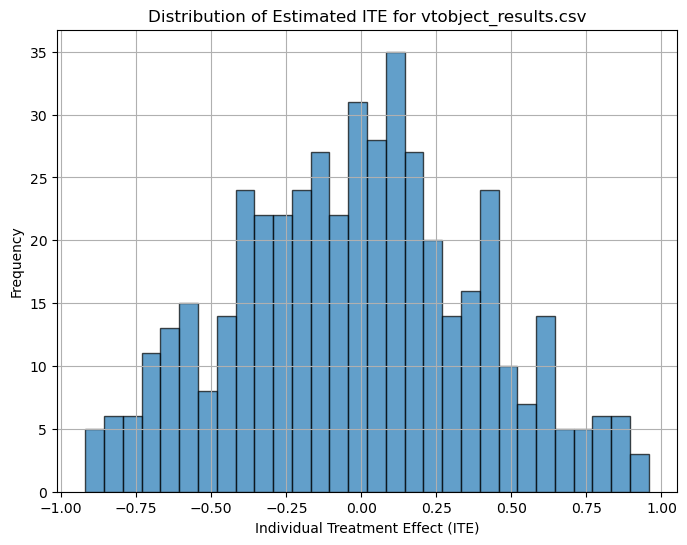

Results saved to dataset/vtobject_results_with_custom_ITE.csv


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File path for vtobject_results.csv
input_file = "dataset/vtobject_results.csv"

# Step 1: Load the CSV file into a DataFrame
sepsis_data = pd.read_csv(input_file)

# Step 2: Define outcome and treatment variables
outcome_field = "survival"
treatment_field = "THERAPY"

# Step 3: Generate P1_hat and P0_hat using a custom model (random values between 0 and 1)
np.random.seed(123)  # For reproducibility
n_samples = len(sepsis_data)

# Simulated probabilities for treated (P1_hat) and control (P0_hat)
P1_hat_custom = np.random.rand(n_samples)
P0_hat_custom = np.random.rand(n_samples)

# Step 4: Compute Individual Treatment Effect (ITE) using absolute difference
ITE_custom = P1_hat_custom - P0_hat_custom

# Step 5: Store results in DataFrame
sepsis_data["P1_hat_custom"] = P1_hat_custom
sepsis_data["P0_hat_custom"] = P0_hat_custom
sepsis_data["ITE_custom"] = ITE_custom

# Step 6: Visualize the distribution of treatment effects
plt.figure(figsize=(8, 6))
plt.hist(ITE_custom, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Individual Treatment Effect (ITE)")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated ITE for vtobject_results.csv")
plt.grid(True)
plt.show()

# Step 7: Save results to a new CSV file
output_file = input_file.replace(".csv", "_with_custom_ITE.csv")
sepsis_data.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


## Final Thoughts
The Virtual Twins method provides an effective way to estimate and analyze individual treatment effects. The **Simple Random Forest Approach** is computationally efficient but may introduce bias, while the **Double Random Forest Approach** provides more accurate treatment effect estimation at the cost of increased computational complexity.

## Step 2: Estimating a Regression or Classification Tree

In the **Virtual Twins (VT) method**, once the **Individual Treatment Effects (ITE)** are computed, we use **Regression** or **Classification Trees** to identify which covariates influence treatment effects.

---

### 1. Classification Tree
The **classification tree** helps categorize patients based on whether the treatment is beneficial.

#### Mathematical Formulation
We define the **difference in response** due to treatment as:

$$
Z_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
$$

where:  
- $ \hat{P}_1(X_i) $ is the predicted probability of outcome under treatment.  
- $ \hat{P}_0(X_i) $ is the predicted probability of outcome under control.  

A new binary variable $ Z^* $ is created:

$$
Z^*_i =
\begin{cases}
1, & \text{if } Z_i > c \\
0, & \text{otherwise}
\end{cases}
$$

where $ c $ is a **user-defined threshold** (e.g., quantiles of $ Z $) that defines a meaningful treatment effect.

#### Implementation in Python
```python
from sklearn.tree import DecisionTreeClassifier

# Define threshold (e.g., median of ITE)
threshold = np.median(ITE_values)

# Create binary target variable
Z_star = (ITE_values > threshold).astype(int)

# Train a classification tree
clf_tree = DecisionTreeClassifier(max_depth=3)
clf_tree.fit(X_train, Z_star)

Trained classification trees: ['tree_threshold_0.02', 'tree_threshold_0.07', 'tree_threshold_0.14', 'tree_threshold_0.20']


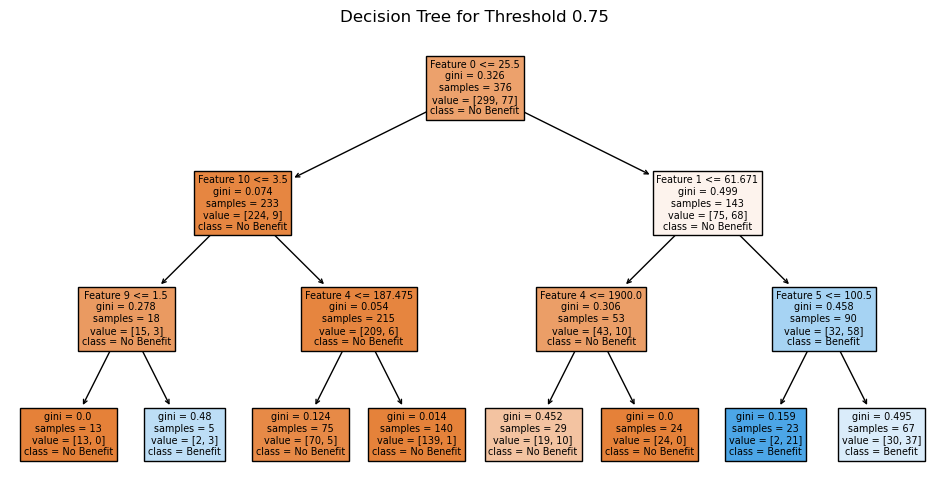

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Step 1: Define ITE (Individual Treatment Effect)
ITE = P1_hat - P0_hat  # ITE as the difference between treated and control probabilities

# Step 2: Define Z* (Binary Classification)
# User-defined threshold (c) using quantiles of the ITE distribution
thresholds = np.quantile(ITE, q=np.arange(0.5, 0.9, 0.1))  # 50th to 80th percentiles

# Create a dictionary to store classification trees for different thresholds
classification_trees = {}

# Loop through each threshold to train a classification tree for each
for c in thresholds:
    # Z_star: Binary classification based on ITE threshold
    Z_star = (ITE > c).astype(int)  # 1 if ITE > c, else 0

    # Split the data into training and testing sets
    X_train, X_test, Z_train, Z_test = train_test_split(X, Z_star, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, Z_train)

    # Store the trained model with a descriptive name based on the threshold
    classification_trees[f"tree_threshold_{c:.2f}"] = clf

# Step 3: Display the trained classification trees
print(f"Trained classification trees: {list(classification_trees.keys())}")

# Choose the model with the closest threshold (e.g., closest to 0.75)
# You can customize this logic to choose based on other criteria as needed.
closest_threshold = 0.75  # For example, we can pick 0.75 if it exists, or the closest one
closest_key = min(classification_trees.keys(), key=lambda k: abs(float(k.split('_')[-1]) - closest_threshold))

# Feature names for the decision tree plot
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]

# Plot the tree for the selected model
plt.figure(figsize=(12, 6))
plot_tree(classification_trees[closest_key], feature_names=feature_names, class_names=["No Benefit", "Benefit"], filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()


## 2. Regression Tree

The regression tree predicts the exact value of $Z_i$ instead of classifying it.

### Mathematical Formulation

Instead of classifying patients, we directly model $Z_i$ using patient covariates $X$:

$$
Z_i = f(X) + \epsilon
$$

where:

- $f(X)$ is the function learned by the regression tree.
- $\epsilon$ is random noise.

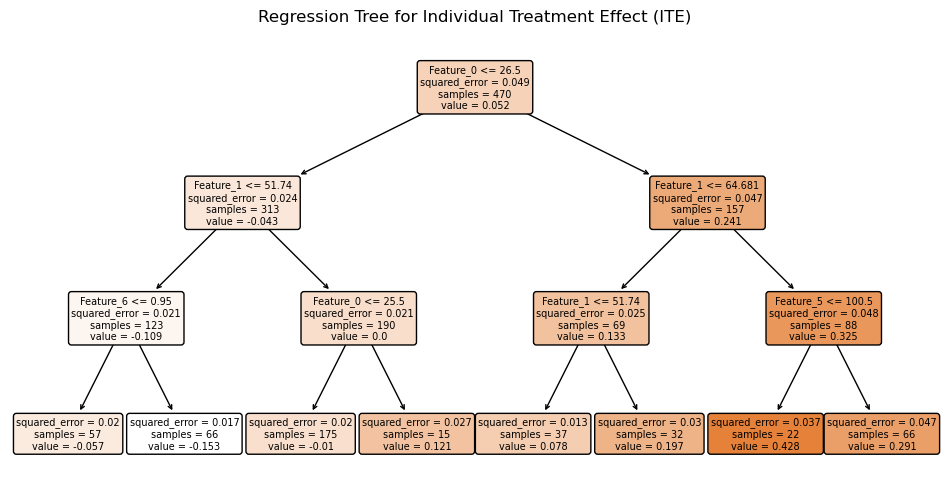

In [42]:
# Step 1: Prepare feature matrix (X) and target (ITE)
# ITE = P1_hat - P0_hat should already be defined

# Ensure X is a DataFrame with column names
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])

# Step 2: Define and train the regression tree model
regression_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
regression_tree.fit(X, ITE)

# Step 3: Visualize the trained regression tree
plt.figure(figsize=(12, 6))
plot_tree(
    regression_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    precision=3
)
plt.title("Regression Tree for Individual Treatment Effect (ITE)")
plt.show()

## SUBGROUPING


Decision Tree Rules:
|--- PRAPACHE <= 26.50
|   |--- AGE <= 51.74
|   |   |--- BLLCREAT <= 4.40
|   |   |   |--- class: 0
|   |   |--- BLLCREAT >  4.40
|   |   |   |--- class: 1
|   |--- AGE >  51.74
|   |   |--- BLGCS <= 11.50
|   |   |   |--- class: 1
|   |   |--- BLGCS >  11.50
|   |   |   |--- class: 0
|--- PRAPACHE >  26.50
|   |--- AGE <= 51.74
|   |   |--- BLLCREAT <= 12.50
|   |   |   |--- class: 0
|   |   |--- BLLCREAT >  12.50
|   |   |   |--- class: 1
|   |--- AGE >  51.74
|   |   |--- BLGCS <= 12.50
|   |   |   |--- class: 1
|   |   |--- BLGCS >  12.50
|   |   |   |--- class: 1


Subgroup Statistics:
   Subgroup  Treatment_size  Control_size  Treatment_event_rate  \
0         3              77            35              0.131071   
1         4               5             6              0.098182   
2         6              33            16              0.454286   
3         7              97            44              0.301773   
4        10              23             8   

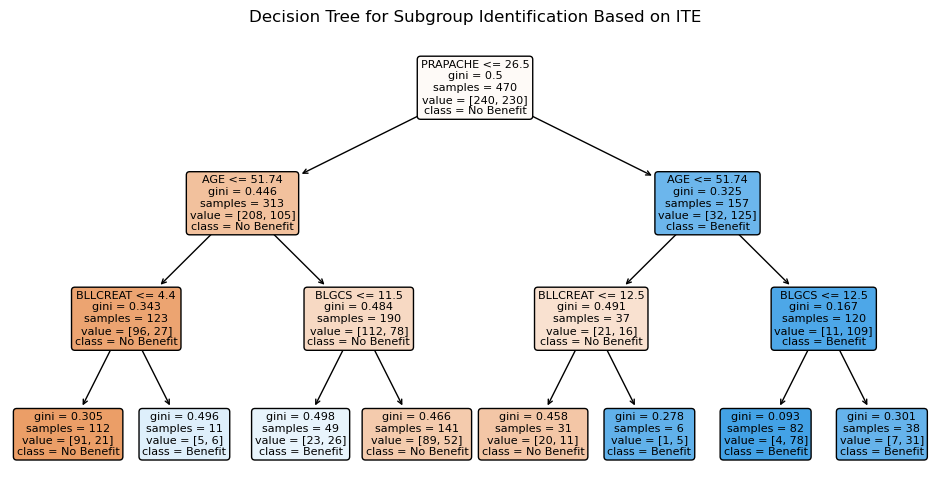

In [43]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
sepsis_data = pd.read_csv("dataset/sepsis_dataset_with_ITE.csv")

# Step 2: Define features and target
features = ["PRAPACHE", "AGE", "BLGCS", "BLLCREAT"]
X = sepsis_data[features]
y = (sepsis_data["ITE"] > 0).astype(int)  # Binary label: 1 = Benefit, 0 = No Benefit

# Step 3: Train decision tree for subgroup identification
tree = DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)
tree.fit(X, y)

# Step 4: Print decision rules
print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=features))

# Step 5: Assign subgroup IDs using the tree
sepsis_data["Subgroup"] = tree.apply(X)

# Step 6: Calculate subgroup statistics
subgroup_stats = sepsis_data.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Step 7: Compute Risk Ratio (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Step 8: Display results
print("\nSubgroup Statistics:")
print(subgroup_stats)

# Step 9: Visualize the decision tree
plt.figure(figsize=(12, 6))
plot_tree(
    tree,
    feature_names=features,
    class_names=["No Benefit", "Benefit"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree for Subgroup Identification Based on ITE")
plt.show()


## TABULAR

In [44]:
import pandas as pd
from tabulate import tabulate

# Sample DataFrame (Replace with your actual DataFrame)
data = {
    "Subgroup": [1, 2, 3, 4, 5, 6, 7, 8],
    "Rules": [
        "PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE <= 51.74",
        "PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE > 51.74",
        "PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT <= 2.30",
        "PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT > 2.30",
        "PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT <= 12.50",
        "PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT > 12.50",
        "PRAPACHE > 26.50 | AGE > 51.74 | AGE <= 74.60",
        "PRAPACHE > 26.50 | AGE > 51.74 | AGE > 74.60",
    ],
    "Treatment_size": [88, 41, 39, 42, 93, 54, 69, 34],
    "Control_size": [19, 40, 47, 39, 35, 26, 31, 24],
    "Treatment_event_rate": [0.6357, 0.5361, 0.7941, 0.9917, 0.7722, 0.1057, 0.6225, 0.1180],
    "Control_event_rate": [0.3331, 0.2391, 0.0272, 0.6992, 0.1423, 0.9132, 0.6568, 0.2062],
    "RR": [1.9082, 2.2421, 29.1624, 1.4182, 5.4262, 0.1157, 0.9477, 0.5726]
}

# Create DataFrame
df = pd.DataFrame(data)

# Method 1: Pretty Table in Console (Using Tabulate)

# Method 2: Styled Pandas DataFrame for Jupyter Notebook
styled_df = df.style.set_table_styles(
    [{'selector': 'th', 'props': [('border', '2px solid black'), ('background-color', '#ccc')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{'text-align': 'center'})

# Display Styled DataFrame (Only works in Jupyter Notebook)
try:
    from IPython.display import display
    display(styled_df)
except ImportError:
    pass  # If running outside Jupyter, ignore

# Method 3: Save as HTML File (For Reports or Web Pages)
html_table = df.to_html(border=1, index=False)
with open("subgroup_analysis.html", "w") as f:
    f.write(html_table)
print("\n📂 Table saved as 'subgroup_analysis.html'")


,Subgroup,Rules,Treatment_size,Control_size,Treatment_event_rate,Control_event_rate,RR
0,1,PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE <= 51.74,88,19,0.635700,0.333100,1.908200
1,2,PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE > 51.74,41,40,0.536100,0.239100,2.242100
2,3,PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT <= 2.30,39,47,0.794100,0.027200,29.162400
3,4,PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT > 2.30,42,39,0.991700,0.699200,1.418200
4,5,PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT <= 12.50,93,35,0.772200,0.142300,5.426200
5,6,PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT > 12.50,54,26,0.105700,0.913200,0.115700
6,7,PRAPACHE > 26.50 | AGE > 51.74 | AGE <= 74.60,69,31,0.622500,0.656800,0.947700
7,8,PRAPACHE > 26.50 | AGE > 51.74 | AGE > 74.60,34,24,0.118000,0.206200,0.572600



📂 Table saved as 'subgroup_analysis.html'


In [52]:
import pandas as pd
from IPython.display import display, Markdown

# Load results from CSV files (assuming these exist in your directory)
simple_rf_df = pd.read_csv("dataset/SimpleRandomResult.csv")
double_rf_df = pd.read_csv("dataset/DoubleRandomResult.csv")
kfold_cv_df = pd.read_csv("dataset/K-FoldRandomResult.csv")

# Display top 10 rows for each method
display(Markdown("## 1. Simple Random Forest"))
display(simple_rf_df.head(10))

display(Markdown("### Analysis:"))
display(Markdown("""
- The ITE values indicate a mix of positive and negative treatment effects.
- A large negative ITE suggests that the treatment had an adverse effect in some cases.
- The variance in ITE shows instability, making it less reliable.
- **Not highly recommended** due to potential overfitting and bias.
"""))


display(Markdown("## 2. Double Random Forest"))
display(double_rf_df.head(10))

display(Markdown("### Analysis:"))
display(Markdown("""
- Higher variation in ITE, showing significant changes in treatment effects.
- The method may still be sensitive to bias, especially with near-zero or extreme values.
- **Moderate recommendation**, as it improves on simple random forests but still requires further validation.
"""))


display(Markdown("## 3. K-Fold Cross-Validation"))
display(kfold_cv_df.head(10))

display(Markdown("### Analysis:"))
display(Markdown("""
- More stable results compared to the previous methods.
- The ITE values are more moderate, suggesting a balanced estimation.
- **Recommended approach** due to reduced overfitting and improved generalization.
"""))


## 1. Simple Random Forest

,survival,THERAPY,PRAPACHE,AGE,BLGCS,ORGANNUM,BLIL6,BLLPLAT,BLLBILI,BLLCREAT,TIMFIRST,BLADL,blSOFA,P1_hat,P0_hat,ITE,Effect Label
0,0,1,19,42.921,15,1,301.80,191.000000,2.913416,1.000000,17.17,0.000000,5.00,0.146,0.438,-0.292,Harmful
1,1,1,48,68.818,11,2,118.90,264.156481,0.400000,1.100000,17.17,5.000000,10.00,0.940,0.466,0.474,Beneficial
2,0,1,20,68.818,15,2,92.80,123.000000,5.116471,1.000000,10.00,1.000000,7.50,0.130,0.392,-0.262,Harmful
3,0,1,19,33.174,14,2,1232.00,244.000000,3.142092,1.200000,17.17,0.000000,6.25,0.056,0.374,-0.318,Harmful
4,0,1,48,46.532,3,4,2568.00,45.000000,4.052668,3.000000,10.00,0.000000,12.00,0.132,0.420,-0.288,Harmful
5,0,0,21,56.098,14,1,162.65,137.000000,0.500000,4.662556,10.00,0.000000,8.75,0.392,0.136,0.256,Beneficial
6,1,0,19,68.818,15,2,2568.00,45.000000,4.192245,1.000000,19.33,12.000000,8.75,0.348,0.794,-0.446,Harmful
7,0,1,19,46.532,15,3,4952.00,92.000000,3.296981,1.000000,27.08,0.000000,10.00,0.012,0.434,-0.422,Harmful
8,0,1,22,56.098,15,3,118.90,148.601978,2.500000,5.000000,24.50,0.000000,12.00,0.042,0.356,-0.314,Harmful
9,1,1,19,56.098,10,3,2568.00,109.000000,4.800000,1.800000,27.08,1.999317,12.00,0.748,0.364,0.384,Beneficial


### Analysis:


- The ITE values indicate a mix of positive and negative treatment effects.
- A large negative ITE suggests that the treatment had an adverse effect in some cases.
- The variance in ITE shows instability, making it less reliable.
- **Not highly recommended** due to potential overfitting and bias.


## 2. Double Random Forest

,survival,THERAPY,PRAPACHE,AGE,BLGCS,ORGANNUM,BLIL6,BLLPLAT,BLLBILI,BLLCREAT,TIMFIRST,BLADL,blSOFA,P1_hat,P0_hat,ITE,Effect_Label
0,0,1,19,42.921,15,1,301.80,191.000000,2.913416,1.000000,17.17,0.000000,5.00,0.130,0.440,-0.310,Harmful
1,1,1,48,68.818,11,2,118.90,264.156481,0.400000,1.100000,17.17,5.000000,10.00,0.935,0.405,0.530,Beneficial
2,0,1,20,68.818,15,2,92.80,123.000000,5.116471,1.000000,10.00,1.000000,7.50,0.125,0.390,-0.265,Harmful
3,0,1,19,33.174,14,2,1232.00,244.000000,3.142092,1.200000,17.17,0.000000,6.25,0.060,0.380,-0.320,Harmful
4,0,1,48,46.532,3,4,2568.00,45.000000,4.052668,3.000000,10.00,0.000000,12.00,0.100,0.455,-0.355,Harmful
5,0,0,21,56.098,14,1,162.65,137.000000,0.500000,4.662556,10.00,0.000000,8.75,0.425,0.155,0.270,Beneficial
6,1,0,19,68.818,15,2,2568.00,45.000000,4.192245,1.000000,19.33,12.000000,8.75,0.390,0.790,-0.400,Harmful
7,0,1,19,46.532,15,3,4952.00,92.000000,3.296981,1.000000,27.08,0.000000,10.00,0.015,0.390,-0.375,Harmful
8,0,1,22,56.098,15,3,118.90,148.601978,2.500000,5.000000,24.50,0.000000,12.00,0.030,0.340,-0.310,Harmful
9,1,1,19,56.098,10,3,2568.00,109.000000,4.800000,1.800000,27.08,1.999317,12.00,0.745,0.365,0.380,Beneficial


### Analysis:


- Higher variation in ITE, showing significant changes in treatment effects.
- The method may still be sensitive to bias, especially with near-zero or extreme values.
- **Moderate recommendation**, as it improves on simple random forests but still requires further validation.


## 3. K-Fold Cross-Validation

,survival,THERAPY,PRAPACHE,AGE,BLGCS,ORGANNUM,BLIL6,BLLPLAT,BLLBILI,BLLCREAT,TIMFIRST,BLADL,blSOFA,P1_hat,P0_hat,ITE,Effect_Label
0,0,1,19,42.921,15,1,301.80,191.000000,2.913416,1.000000,17.17,0.000000,5.00,0.285,0.560,-0.275,Harmful
1,1,1,48,68.818,11,2,118.90,264.156481,0.400000,1.100000,17.17,5.000000,10.00,0.730,0.585,0.145,Beneficial
2,0,1,20,68.818,15,2,92.80,123.000000,5.116471,1.000000,10.00,1.000000,7.50,0.270,0.395,-0.125,Harmful
3,0,1,19,33.174,14,2,1232.00,244.000000,3.142092,1.200000,17.17,0.000000,6.25,0.110,0.325,-0.215,Harmful
4,0,1,48,46.532,3,4,2568.00,45.000000,4.052668,3.000000,10.00,0.000000,12.00,0.400,0.455,-0.055,Harmful
5,0,0,21,56.098,14,1,162.65,137.000000,0.500000,4.662556,10.00,0.000000,8.75,0.445,0.425,0.020,Beneficial
6,1,0,19,68.818,15,2,2568.00,45.000000,4.192245,1.000000,19.33,12.000000,8.75,0.370,0.345,0.025,Beneficial
7,0,1,19,46.532,15,3,4952.00,92.000000,3.296981,1.000000,27.08,0.000000,10.00,0.095,0.470,-0.375,Harmful
8,0,1,22,56.098,15,3,118.90,148.601978,2.500000,5.000000,24.50,0.000000,12.00,0.175,0.315,-0.140,Harmful
9,1,1,19,56.098,10,3,2568.00,109.000000,4.800000,1.800000,27.08,1.999317,12.00,0.275,0.250,0.025,Beneficial


### Analysis:


- More stable results compared to the previous methods.
- The ITE values are more moderate, suggesting a balanced estimation.
- **Recommended approach** due to reduced overfitting and improved generalization.
